In [1]:
import numpy as np 
import pandas as pd
import shap
from sklearn.datasets import load_boston

boston = load_boston()
df = pd.DataFrame(data=boston.data,columns=boston.feature_names)
df['target']=boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [2]:
from sklearn.model_selection import train_test_split

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination='auto', max_features=13, 
                          bootstrap=False, n_jobs=-1, random_state=42)

iforest.fit(X)

y_pred = iforest.predict(X)

df['anomaly_label']=y_pred
print(df.anomaly_label.unique())
df[df.anomaly_label==-1].head()

[ 1 -1]


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target,anomaly_label
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5,-1
54,0.01360,75.0,4.00,0.0,0.410,5.888,47.6,7.3197,3.0,469.0,21.1,396.90,14.80,18.9,-1
57,0.01432,100.0,1.32,0.0,0.411,6.816,40.5,8.3248,5.0,256.0,15.1,392.90,3.95,31.6,-1
141,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,14.4,-1
142,3.32105,0.0,19.58,1.0,0.871,5.403,100.0,1.3216,5.0,403.0,14.7,396.90,26.82,13.4,-1


In [4]:
df['target']=df['anomaly_label'].apply(lambda x: 1 if x==-1 else 0)

In [5]:
!pip install pygam

     |████████████████████████████████| 1.8 MB 1.0 MB/s 


In [6]:
from pygam import LogisticGAM, s, f
from pygam.datasets import default
import matplotlib.pyplot as plt

In [7]:
len(X[0])

KeyError: 0

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


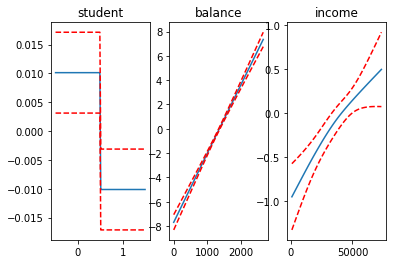

In [8]:
X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ['student', 'balance', 'income']

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [9]:
df.drop(['target','anomaly_label'],axis=1).columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [10]:
X = df.drop(['target','anomaly_label'],axis=1).values
y = df.target.values

In [11]:
len(X[0])

13

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--divide by zero encountered in true_divide
invalid value encountered in multiply
  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01divide by zero encountered in true_divide
invalid value encountered in multiply
 18% (2 of 11) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:01divide by zero encountered in true_divide
invalid value encountered in multiply
100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

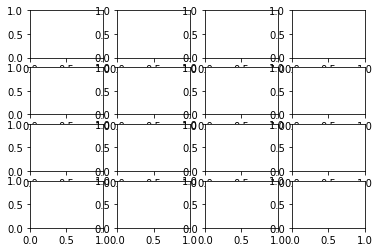

In [12]:
#X, y = default(return_X_y=True)

gam = LogisticGAM(s(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(4, 4)
titles = list(df.drop(['target','anomaly_label'],axis=1).columns)

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

In [13]:
gam.accuracy(X, y)

0.8853754940711462

In [14]:
XX = generate_X_grid(gam)
plt.rcParams['figure.figsize'] = (28, 8)
fig, axs = plt.subplots(1, len(data.feature_names[0:6]))
titles = data.feature_names
for i, ax in enumerate(axs):
    pdep, confi = gam.partial_dependence(XX, feature=i+1, width=.95)
    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi[0][:, 0], c='grey', ls='--')
    ax.plot(XX[:, i], confi[0][:, 1], c='grey', ls='--')
    ax.set_title(titles[i])
plt.show()

NameError: name 'generate_X_grid' is not defined

## Visualize Tree

In [15]:
dir(iforest)

['__abstractmethods__',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_check_n_features',
 '_compute_chunked_score_samples',
 '_compute_score_samples',
 '_estimator_type',
 '_fit',
 '_get_estimators_indices',
 '_get_param_names',
 '_get_tags',
 '_make_estimator',
 '_max_features',
 '_max_samples',
 '_more_tags',
 '_n_samples',
 '_parallel_args',
 '_repr_html_',
 '_repr_html_inner',
 '_repr_mimebundle_',
 '_required_parameters',
 '_seeds',
 '_set_oob_score',
 '_validate_data',
 '_validate_estimator',
 '_validate_y',
 'base_estimator',
 'base_estimator_',
 'boo

In [16]:
!pip install dtreeviz

     |████████████████████████████████| 60 kB 672 kB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3-py3-none-any.whl size=66638 sha256=c3c13feb3fed58eec25534b22d999803943ecb781ea88228982b6013d886f36e
  Stored in directory: /root/.cache/pip/wheels/9f/a6/a1/898c991294471015f13c1e5b456fb8134c1af835db4dd93a7a
Successfully built dtreeviz
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.8.4
    Uninstalling graphviz-0.8.4:
      Successfully uninstalled graphviz-0.8.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mxnet 1.8.0.post0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.16 which is incompatible.
autogluon-core 0.1.0 requires graphviz<0.9.0,>=0.8.1, but you have graphviz 0.16 which is incompatible.


In [17]:
iforest.estimators_[5]
estimator = iforest.estimators_[5]

In [18]:
from sklearn.tree import export_graphviz

In [19]:
export_graphviz(estimator,out_file='tree.dot',max_depth=4,feature_names = boston.feature_names,special_characters=True,rounded=True,precision=2,class_names=['-1','1'])

In [20]:
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [21]:
from IPython.display import Image
Image(filename = 'tree.png')

## shap.KernelExplainer

In [22]:
explainer = shap.KernelExplainer(iforest.predict, X)
shap_values = explainer.shap_values(X)

  0%|          | 0/506 [00:00<?, ?it/s]

In [23]:
import joblib

In [24]:
def shap_save_to_disk(self):
    print("Saving SHAP to .h5 file...")
    h5_file = self.h5_file
    shap_val_df = pd.DataFrame(self.shap_values) #this step is unnecessary, could just save np arrays directly, but the df have some advantages and I don't mind reconverting upon loading
    shap_feat_df = pd.DataFrame(self.features_shap)
    # define what goes in the first row with "d"
    d = [[self.target, self.name_for_figs, self.shap_expected, self.class_thresh]]
    exp_df = pd.DataFrame(
        d, columns=("target", "name_for_figs", "shap_exp_val", "class_thresh")
    )
    shap_val_df.to_hdf(h5_file, key="shap_values", format="table")
    shap_feat_df.to_hdf(h5_file, key="features_shap", format="table")
    exp_df.to_hdf(h5_file, key="shap_expected_value", format="table")

In [25]:
shap_values

array([[ 0.12795523, -0.07507073, -0.12244761, ..., -0.06793562,
         0.12189933,  0.10734846],
       [ 0.05185719,  0.04839888, -0.02181206, ...,  0.0300145 ,
         0.12217602,  0.04665454],
       [ 0.08253544,  0.0411358 , -0.01677181, ...,  0.02690396,
         0.13552443,  0.00460262],
       ...,
       [ 0.05555495,  0.12084104, -0.03740372, ...,  0.00501838,
         0.11588298,  0.01500215],
       [ 0.04160196,  0.10792379, -0.027069  , ...,  0.00865321,
         0.12102862,  0.02598015],
       [ 0.04240305,  0.11576515, -0.03009738, ...,  0.00466851,
         0.11586478,  0.03153197]])

## Explainer and Shapley values

In [26]:
dir(shap)

['ActionOptimizer',
 'AdditiveExplainer',
 'Cohorts',
 'DeepExplainer',
 'Explainer',
 'Explanation',
 'GPUTreeExplainer',
 'GradientExplainer',
 'KernelExplainer',
 'LinearExplainer',
 'PartitionExplainer',
 'PermutationExplainer',
 'SamplingExplainer',
 'TreeExplainer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_cext',
 '_explanation',
 '_serializable',
 'actions',
 'approximate_interactions',
 'bar_plot',
 'datasets',
 'decision_plot',
 'dependence_plot',
 'embedding_plot',
 'explainers',
 'force_plot',
 'getjs',
 'group_difference_plot',
 'have_matplotlib',
 'image_plot',
 'initjs',
 'kmeans',
 'links',
 'maskers',
 'matplotlib',
 'models',
 'monitoring_plot',
 'multioutput_decision_plot',
 'other',
 'partial_dependence_plot',
 'plots',
 'sample',
 'save_html',
 'summary_plot',
 'sys',
 'text_plot',
 'unsupported',
 'utils',
 'warnings',
 'waterfall_plot']

In [27]:
print(shap.__version__)

0.39.0


In [28]:
explainer = shap.Explainer(iforest.predict, X)
shap_values = explainer(X)

Permutation explainer: 507it [07:52,  1.06it/s]


In [29]:
shap.initjs()

## force plot

In [30]:
shap.plots.force(shap_values[142])

In [31]:
df.loc[142]

CRIM               3.32105
ZN                 0.00000
INDUS             19.58000
CHAS               1.00000
NOX                0.87100
RM                 5.40300
AGE              100.00000
DIS                1.32160
RAD                5.00000
TAX              403.00000
PTRATIO           14.70000
B                396.90000
LSTAT             26.82000
target             1.00000
anomaly_label     -1.00000
Name: 142, dtype: float64

In [32]:
shap.plots.force(shap_values[0])

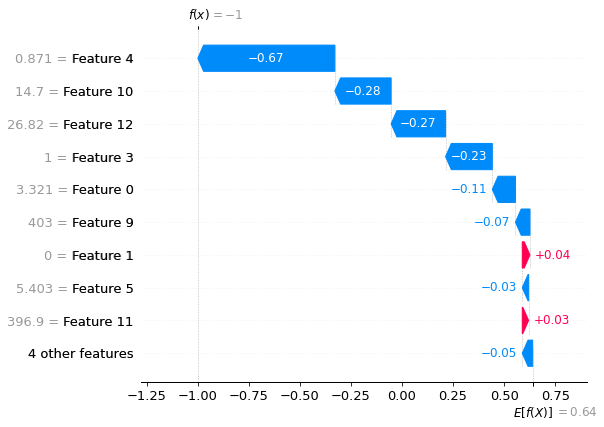

In [33]:
shap.plots.waterfall(shap_values[142])

## Explain single feature 

In [34]:
shap.plots.scatter(shap_values[:,'NOX'], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [35]:
shap.plots.scatter(shap_values[:,'CRIM'], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [36]:
shap.plots.scatter(shap_values[:,'RM'], color=shap_values)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [37]:
shap.plots.partial_dependence("AGE", iforest.predict, X, ice=False, model_expected_value=True, feature_expected_value=True)

ValueError: Could not find feature named: AGE

## Global interpratability --> summary plot

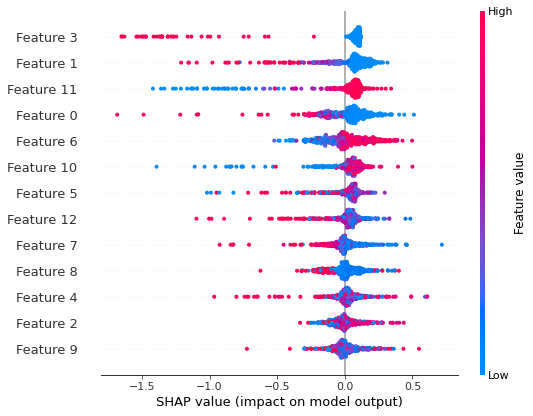

In [38]:
shap.summary_plot(shap_values, X)

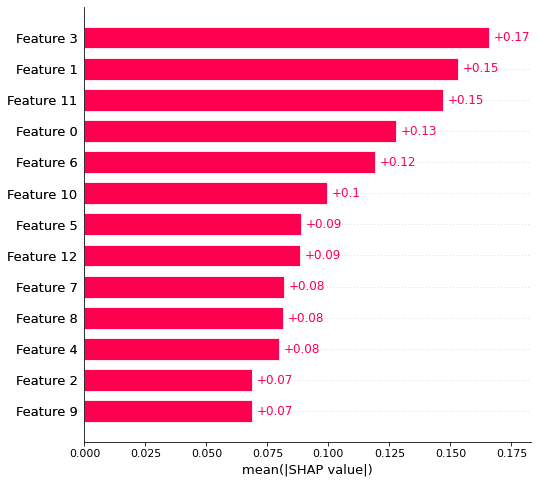

In [39]:
shap.plots.bar(shap_values,max_display=14)